Can we predict how well wine will be recieved based on chemical makeup?
==========================================================================

Kinda a neat question that Manu Jeevan did a writeup on.  

   * [kdnuggets - wine prediction](http://www.kdnuggets.com/2016/04/unbalanced-classes-svm-random-forests-python.html)
   * [UCI website with reference and data]](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

We work with unbalanced classes, SVMs, and random forests in this example.

Imports
----------------------------------

In [56]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import scipy as sp
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

Load data
--------------

In [57]:
dataDir = os.path.join(os.path.expanduser('~'),'data','ml','winequality')
wine_df = pd.read_csv(os.path.join(dataDir,'winequality-red.csv'), sep=';')
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


Create the matrix and simplify the classification space

In [58]:
Y = wine_df.quality.values
wine_df = wine_df.drop('quality',axis=1)
print(Y[:10])

Y = np.asarray([1 if i>=7 else 0 for i in Y])
X = wine_df.as_matrix()
print X.shape
print(Y[:10])

[5 5 5 6 5 5 5 7 7 5]
(1599, 11)
[0 0 0 0 0 0 0 1 1 0]


Random Forest
------------------------

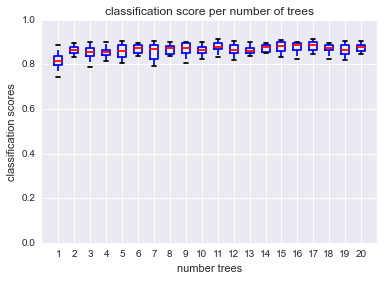

In [61]:
scores = []
for val in range(1,21):
    clf = RandomForestClassifier(n_estimators=val)
    validated = cross_val_score(clf,X,Y,cv=10)
    scores.append(validated)

#print len(scores)
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.boxplot(scores)
ax.set_ylim((0,1))
ax.set_xlim((0,21))
#sns.boxplot(scores)
plt.xlabel("number trees")
plt.ylabel("classification scores")
plt.title("classification score per number of trees")
plt.show()

Unbalanced design
------------------------

Classification accuracy can be misleading in cases where we have an unbalanced design so use F1 scores instead.


20


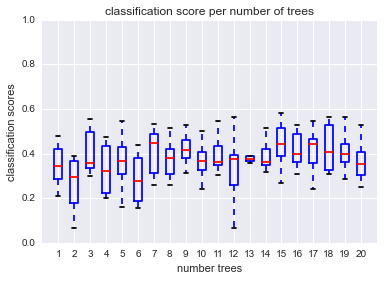

In [60]:
scores = []
for val in range(1,21):
    clf = RandomForestClassifier(n_estimators=val)
    validated = cross_val_score(clf,X,Y,cv=10,scoring='f1')
    scores.append(validated)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.boxplot(scores)
ax.set_ylim((0,1))
ax.set_xlim((0,21))
plt.xlabel("number trees")
plt.ylabel("classification scores")
plt.title("classification score per number of trees")
plt.show()

In short , we don't see much gain by increasing the number of trees.  The predict_proba function returns the probability for each class, but for many classifiers the accuracy of these values can become an issue if the class structure is highly unbalanced.  So normally we call a class if this prob is >0.5, but we cannot trust this value so we can use cross-validation to find the best one.

In [80]:
print("total normals: %s/%s"%(np.where(Y==0)[0].size,Y.size))

total normals: 1382/1599


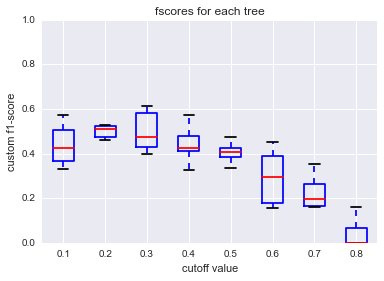

In [81]:
def cutoff_predict(clf,X,cutoff):
    return (clf.predict_proba(X)[:,1] > cutoff).astype(int)

scores = []
def custom_f1(cutoff):
    def f1_cutoff(clf,X,Y):
        ypred = cutoff_predict(clf,X,cutoff)
        return sklearn.metrics.f1_score(Y,ypred)
    
    return f1_cutoff

parmRange = np.arange(0.1,0.9,0.1)
for cutoff in parmRange:
    clf = RandomForestClassifier(n_estimators=15)
    validated = cross_val_score(clf,X,Y,cv=10,scoring=custom_f1(cutoff))
    scores.append(validated)
    
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.boxplot(scores)
ax.set_ylim((0,1))
ax.set_xticklabels(parmRange)
plt.xlabel("cutoff value")
plt.ylabel("custom f1-score")
plt.title("fscores for each tree")
plt.show()


It is intuitive that the cutoff be less than 0.5 because the training data contains many fewer examples of 'good' wines, so we need to adjust the cutoff to reflect that good wines are more rare.

Plotting decision boundries
------------------------------

Random forests allos you to compute a heuristic for determining how important a feature is in predicting a target.  Basically, the more the accuracy drops after sample permutation the more important the feature.

1.0


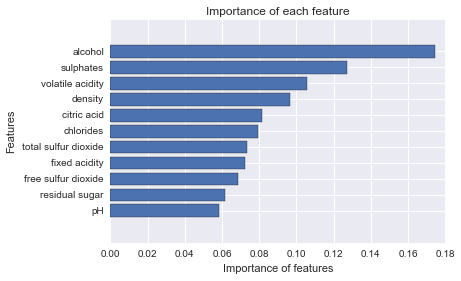

In [85]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(X,Y)
imp = clf.feature_importances_
names = wine_df.columns
imp,names = zip(*sorted(zip(imp,names)))
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
print np.array(list(imp)).sum()
ax.barh(range(len(names)),imp,align='center')
plt.yticks(range(len(names)),names)
plt.xlabel("Importance of features")
plt.ylabel("Features")
plt.title("Importance of each feature")
plt.show()